In [1]:
import csv
import json
import sagemaker
import pickle
import boto3
import pandas as pd
import numpy as np
from sagemaker.amazon.amazon_estimator import RecordSet

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
TEST_SET_RATIO = 0.1
bucket = 'sagemaker-training-02012019'
region = 'us-east-2'
s3_resource = boto3.resource('s3')
role = sagemaker.get_execution_role()

In [3]:
def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 50)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label['predicted_label'].float32_tensor.values
    test_preds = np.concatenate([np.array([extract_label(x) for x in batch]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    
    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)
    
    # calculate precision for each class
    precision_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        precision_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        precision_denominator = np.logical_and(test_preds == target_label, test_labels == target_label).sum() \
                              + np.logical_and(test_preds == target_label, test_labels != target_label).sum()
        precision_per_class.append(precision_numerator / precision_denominator)
        classes.append(label_map[target_label])
    precision = pd.DataFrame({'precision': precision_per_class, 'class_label': classes})
    precision.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    print("the number test labels are \n", len(set((test_labels))))
    print("the test labels are \n", set(label_mapper(test_labels)))
    print("\n the number of test preds are", len(set(label_mapper(test_preds))))
    print("\n the test preds are", set(label_mapper(test_preds)))
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'])

    # display results
   
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(confusion_matrix, annot=True).set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    ay = precision.plot(kind='barh', x='class_label', y='precision', color='steelblue', title='Precision', legend=False)
    ay.set_ylabel('')    
    print('Accuracy: {:.3f}'.format(accuracy))
    

In [4]:
def tranform_textual_input(bucket, observation_str):
    ## might expose this to client in the future ???
    vectorizer_filename = 'tfidf_vectorizer.pickle'
    column_names=['incident_description']
    one_hot_encoded_df = pd.DataFrame(pd.Series(observation_str), 
                                      dtype=np.str, columns=column_names)
    
    s3_resource = boto3.resource('s3')
    s3_resource.meta.client.download_file(bucket, vectorizer_filename, vectorizer_filename)
    tfidf_vectorizer = pickle.load(open(vectorizer_filename, "rb"))
    test_tfidf = tfidf_vectorizer.transform(one_hot_encoded_df['incident_description'])
    test_tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
    for i in range(0, len(test_tfidf_feature_names)):
        one_hot_encoded_df[test_tfidf_feature_names[i]] = test_tfidf[:,i].toarray()
    

    one_hot_encoded_df = one_hot_encoded_df.drop(columns=['incident_description'])
    
    f32_test = one_hot_encoded_df.iloc[0].as_matrix().astype('float32')
    items = [str(item) for item in f32_test]
    items_str = ", ".join(items)
    return items_str

def get_pred(observation_str):
    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=observation_str)
    resp_body = json.loads(response['Body'].read())
    return resp_body['predictions'][0]['predicted_label']

def derive_kb(pred, topKB):
    result = []
    result = [topKB[topKB['mapped_index']==pred]['kb_id'].values.tolist()[:], topKB[topKB['mapped_index']==pred]['kb_title'].values.tolist()[:],
              topKB[topKB['mapped_index']==pred]['kb_affected_release'].values.tolist()[:]]
    return result

In [5]:
bucket='sagemaker-training-02012019'
classif_filename = "debug/labeled_data_classification.csv" 
classif_loc = 's3://{}/{}'.format(bucket, classif_filename)
#download the file from s3
df = pd.read_csv(classif_loc)
print(len(set(df['target_topic'])))

df = df.drop(columns=['customer_name', 'country_name', 'incident_severity',
       'year_create', 'month_create'])
print(df.shape)

12
(1898, 1001)


In [6]:
new_classes = df['target_topic'].unique()
classes_dict = dict(zip(new_classes, range(0,len(new_classes))))
#classes_dict

In [7]:
import pickle
pickle.dump(classes_dict, open("data/labels_dict.pickle", "wb"))
s3_resource.meta.client.upload_file('data/labels_dict.pickle', bucket, 'labels_dict.pickle')

In [8]:
df['target_topic_number'] = df['target_topic'].map(classes_dict)
del df['target_topic']

In [9]:
X = df.iloc[:, :-1]

y = df.iloc[:, -1].astype(str)

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SET_RATIO)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

print(len(set(y_train)))
print(len(set(y_test)))

12
12


In [10]:
multiclass_estimator = sagemaker.LinearLearner(role=role,
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               predictor_type='multiclass_classifier',
                                               balance_multiclass_weights=True,
                                               num_classes=len(classes_dict))

In [11]:
#data transformation in a format acceptable by the linear learner
#put this in a function
X_train_array = X_train.as_matrix().astype('float32')
sagemaker_y_train = y_train.as_matrix().astype('float32')
#X_val_array = X_val.as_matrix().astype('float32')
#sagemaker_y_val = y_val.as_matrix().astype('float32')
X_test_array = X_test.as_matrix().astype('float32')
sagemaker_y_test = y_test.as_matrix().astype('float32')

# wrap data in RecordSet objects
train_records = multiclass_estimator.record_set(X_train_array, sagemaker_y_train, channel='train')
#val_records = multiclass_estimator.record_set(X_val_array, sagemaker_y_val, channel='validation')
test_records = multiclass_estimator.record_set(X_test_array, sagemaker_y_test, channel='test')

#check if we can create a log file to store output of training
multiclass_estimator.fit([train_records, test_records])

2019-05-08 13:52:55 Starting - Starting the training job...
2019-05-08 13:52:57 Starting - Launching requested ML instances......
2019-05-08 13:54:00 Starting - Preparing the instances for training......
2019-05-08 13:54:59 Downloading - Downloading input data...
2019-05-08 13:55:50 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[05/08/2019 13:55:53 INFO 140666097690432] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u


2019-05-08 13:56:08 Uploading - Uploading generated training model
2019-05-08 13:56:08 Completed - Training job completed
Billable seconds: 69


In [12]:
multiclass_predictor = multiclass_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------!

In [13]:
region='us-east-2'
client = boto3.client('sagemaker', region_name=region)
runtime_client = boto3.client('runtime.sagemaker', region_name=region)
#updating with the last endpoint name
#find if we can set the created endpoint name in a parameter
endpoint_name = 'linear-learner-2019-05-08-13-52-55-294'
#client.describe_endpoint(EndpointName=endpoint_name)

In [14]:
label_map = {v: k for k, v in classes_dict.items()}

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in long_scalars


the number test labels are 
 12
the test labels are 
 {'0.042*"order" + 0.035*"invoice" + 0.031*"line" + 0.022*"purchase" + 0.017*"item"', '0.024*"journal" + 0.023*"post" + 0.022*"transaction" + 0.019*"ledger" + 0.019*"code"', '0.024*"balance" + 0.024*"support" + 0.019*"statement" + 0.018*"account" + 0.018*"q"', '0.024*"table" + 0.019*"file" + 0.019*"transfer" + 0.018*"unit" + 0.018*"import"', '0.060*"user" + 0.028*"log" + 0.024*"manager" + 0.017*"service" + 0.017*"requisition"', '0.028*"document" + 0.024*"change" + 0.024*"date" + 0.020*"page" + 0.020*"approval"', '0.026*"allocation" + 0.015*"tax" + 0.015*"team" + 0.012*"request" + 0.012*"source"', '0.025*"sql" + 0.022*"sqlstate" + 0.020*"component" + 0.020*"unexpected" + 0.019*"ion"', '0.038*"version" + 0.035*"patch" + 0.026*"web" + 0.025*"upgrade" + 0.024*"support"', '0.048*"bank" + 0.040*"b" + 0.040*"file" + 0.031*"payment" + 0.025*"format"', '0.041*"server" + 0.021*"application" + 0.019*"ipo" + 0.019*"client" + 0.018*"user"', '0.03

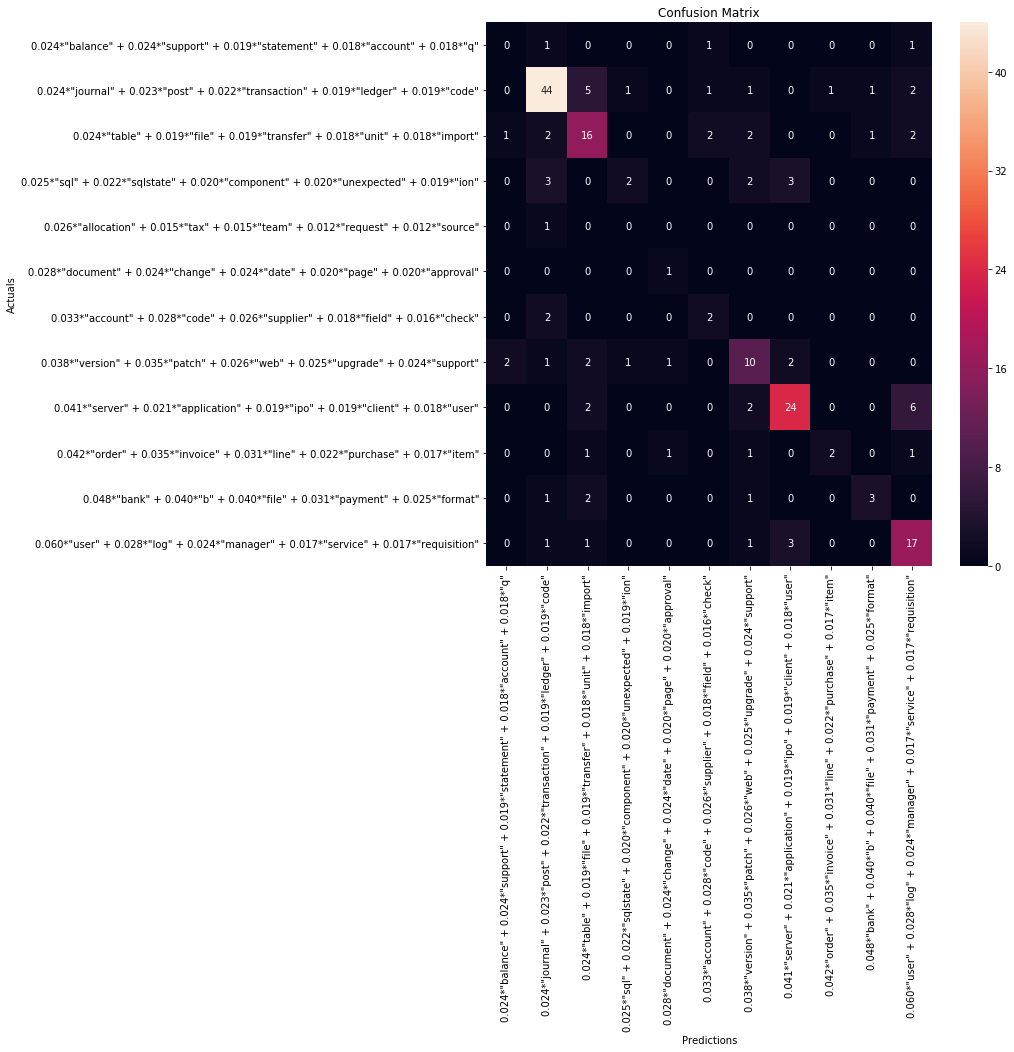

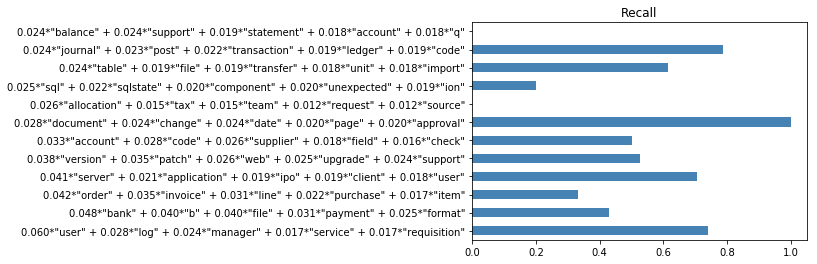

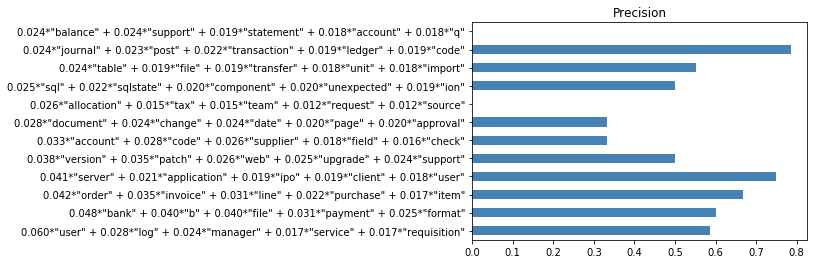

In [15]:
# evaluate metrics of the model trained with default hyperparameters, first execute function below. 
#Train performance
evaluate_metrics(multiclass_predictor, X_test_array, sagemaker_y_test)

the number test labels are 
 12
the test labels are 
 {'0.042*"order" + 0.035*"invoice" + 0.031*"line" + 0.022*"purchase" + 0.017*"item"', '0.024*"journal" + 0.023*"post" + 0.022*"transaction" + 0.019*"ledger" + 0.019*"code"', '0.024*"balance" + 0.024*"support" + 0.019*"statement" + 0.018*"account" + 0.018*"q"', '0.024*"table" + 0.019*"file" + 0.019*"transfer" + 0.018*"unit" + 0.018*"import"', '0.026*"allocation" + 0.015*"tax" + 0.015*"team" + 0.012*"request" + 0.012*"source"', '0.060*"user" + 0.028*"log" + 0.024*"manager" + 0.017*"service" + 0.017*"requisition"', '0.028*"document" + 0.024*"change" + 0.024*"date" + 0.020*"page" + 0.020*"approval"', '0.025*"sql" + 0.022*"sqlstate" + 0.020*"component" + 0.020*"unexpected" + 0.019*"ion"', '0.038*"version" + 0.035*"patch" + 0.026*"web" + 0.025*"upgrade" + 0.024*"support"', '0.048*"bank" + 0.040*"b" + 0.040*"file" + 0.031*"payment" + 0.025*"format"', '0.041*"server" + 0.021*"application" + 0.019*"ipo" + 0.019*"client" + 0.018*"user"', '0.03

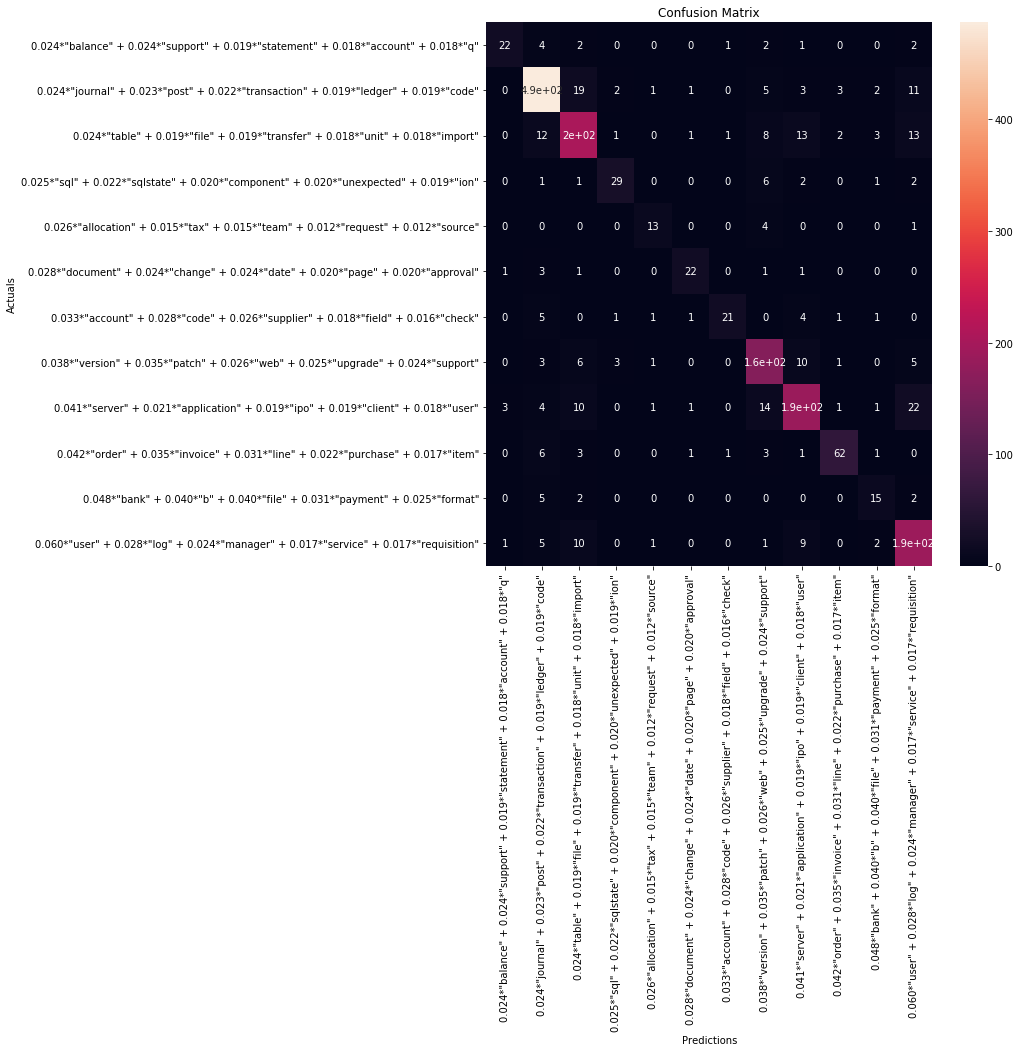

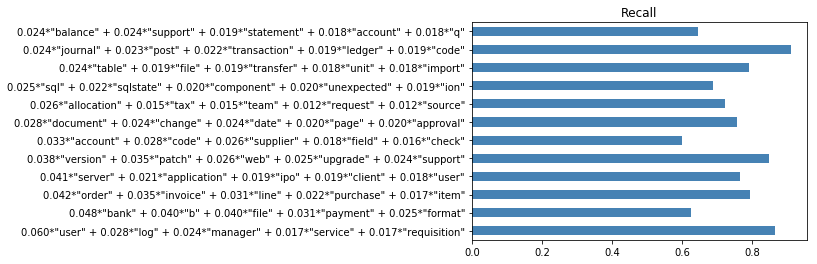

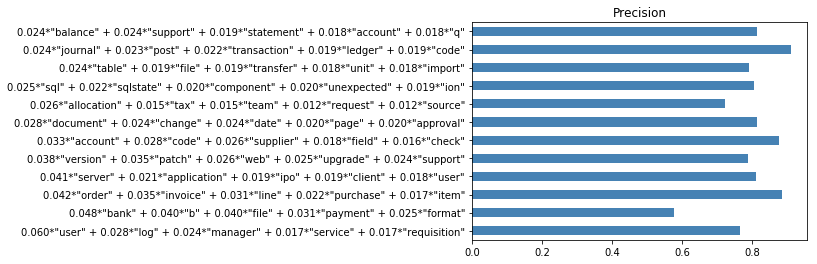

In [16]:
evaluate_metrics(multiclass_predictor, X_train_array, sagemaker_y_train)

In [ ]:
#evaluate_metrics(multiclass_predictor, X_val_array, sagemaker_y_val)

In [37]:
full_df_filename = "debug/full_labeled_data.csv" 
full_location = 's3://{}/{}'.format(bucket, full_df_filename)


load_col=['incident_id', 'customer_name', 'country_name', 'product_name', 'year_create', 'month_create',
          'incident_description', 'kb_title']
col_types={x:str for x in load_col}

#download the file from s3
full_data = pd.read_csv(full_location, usecols=load_col, dtype=col_types)

In [38]:
topKB = pd.read_csv('s3://{}/{}'.format(bucket, 'top3KB_documents.csv'))
topKB['mapped_index'] = topKB['target_topic'].map(classes_dict)

In [41]:
tmp = full_data.incident_description[:20].apply(
    lambda x: tranform_textual_input(bucket, x)).apply(
    lambda x: get_pred(x)).apply(lambda x: derive_kb(x, topKB))
full_data['kb_recommendation']=tmp


In [42]:
full_data

incident_id                             customer_name  \
0         7926220                            Appnexus, Inc.   
1         8205192        Deloitte Touche Tohmatsu India LLP   
2         8435606      Sun Life of Canada (Philippines) Inc   
3         8899596          A&W Food Services of Canada Ltd.   
4         9137047            Shangri-La International Hotel   
5         9226212  First Exploration & Petroleum Developmen   
6         9285834                            Appnexus, Inc.   
7         9363383            Shangri-La International Hotel   
8         9580239             Tata Asset Management Limited   
9         9588643                         EnTrustPermal Ltd   
10        9612825                 Total Gas & Power Limited   
11        9638433               National Crime Agency (NCA)   
12        9644790                          Puspakom Sdn Bhd   
13        9661523                   Fairmont Raffles Hotels   
14        9699571                            Novotel Melaka   
15        9717050                      MNRB Holdings Berhad   
16        9728993                       EDF Trading Limited   
17        9730787                            JAC Travel Ltd   
18        9730787                            JAC Travel Ltd   
19        9803780                                KPMG Ghana   
20        9826844             Transnational Corporation Plc   
21        9839651            General Conference Corporation   
22        9885948                     Safilo Hong Kong Ltd.   
23        9886877  Legal &General Resources Bermuda Limited   
24        9900927         Butterfield & Robinson Management   
25        9931792  National Bureau of Economic Research Inc   
26        9938903                Assicurazioni Generali SPA   
27        9945499            Shangri-La International Hotel   
28       10024619               Lembaga Getah Malaysia (KT)   
29       10027545                       Edmonton Northlands   
...           ...                                       ...   
22575    13358417                                   Primark   
22576    13359410                               SGS Nigeria   
22577    13360158           World Vision International (HQ)   
22578    13361150   F1INFOTECH FZE A Spectrum Group Company   
22579    13361667                Jumeirah International LLC   
22580    13362076       Abercrombie & Kent (Hong Kong) Ltd.   
22581    13362175                            Care Australia   
22582    13362300                 Tokio Marine Asia Pte Ltd   
22583    13362422            State Street Australia Limited   
22584    13362677      Suriwongse Royal Suite Hotel Co. LTD   
22585    13363027                     Travelodge Hotels Ltd   
22586    13363108                  Synergy Software Systems   
22587    13364230                  Noront Resources Limited   
22588    13364357                     Network Housing Group   
22589    13364551                     Network Housing Group   
22590    13364589                           ABC Group, Inc.   
22591    13365649               SS&C Financial Services LLC   
22592    13366143                   Fairmont Raffles Hotels   
22593    13366574    Office of the Communications Authority   
22594    13366745    Office of the Communications Authority   
22595    13366770                        Lincoln University   
22596    13367323                  Robert Dyas Holdings Ltd   
22597    13367370                  Robert Dyas Holdings Ltd   
22598    13367722    Jelas Puri Sdn. Bhd. doing business as   
22599    13367984                Jumeirah International LLC   
22600    13368173                           DG Partners LLP   
22601    13368210                         Gkbk Holdings Ltd   
22602    13368387                Core Financial Systems Ltd   
22603    13368695       National Treasury Management Agency   
22604    13368890                  IDC Asia Pacific Pte Ltd   

               country_name                          product_name  \
0                       USA  I

In [23]:
full_data[full_data['incident_id']=='8205192'].to_csv('data/prediction_test.csv', index=False)

In [43]:
del full_data['kb_title']

In [44]:
#full_data = full_data.dropna(how='any')
full_data.head(5)

incident_id                         customer_name country_name  \
0     7926220                        Appnexus, Inc.          USA   
1     8205192    Deloitte Touche Tohmatsu India LLP        India   
2     8435606  Sun Life of Canada (Philippines) Inc  Philippines   
3     8899596      A&W Food Services of Canada Ltd.       Canada   
4     9137047        Shangri-La International Hotel    Hong Kong   

                           product_name  \
0  Infor SunSystems - Accounting Module   
1                     SN4 - Core Module   
2               SN4 - Ledger Accounting   
3               SN5 - Accounting Module   
4  Infor SunSystems - Accounting Module   

                                incident_description year_create month_create  \
0  Hi,  AppNexus uses the pay-as paid functionali...        2014           10   
1  Hi, We have done fresh installation on Sun 4.3...        2014           12   
2  The difference of .46 in RC offset by Misc Sus...        2015           03   
3  We did our payment run and it got hung up and ...        2015           08   
4  On Nov 11, 2015 around 17:45, a user was doing...        2015           11   

                                   kb_recommendation  
0  [[1700375, 1974841, 1172421, 1108163, 947802, ...  
1  [[652785, 1132260, 1508263, 1951236, 1352051, ...  
2  [[1174684, 954449, 700807, 1108738, 1830693, 1...  
3  [[652785, 1132260, 1508263, 1951236, 1352051, ...  
4  [[1700375, 1974841, 1172421, 1108163, 947802, ...

In [30]:
full_data

incident_id                     customer_name country_name  \
3     8899596  A&W Food Services of Canada Ltd.       Canada   

              product_name                               incident_description  \
3  SN5 - Accounting Module  We did our payment run and it got hung up and ...   

  year_create month_create                                  kb_recommendation  
3        2015           08  [[652785, 1132260, 1508263, 1951236, 1352051, ...

In [45]:
full_data.to_csv('data/kb_recommendations.csv', index=False)